In [1]:
import os
import yaml
import pandas as pd
from collections import defaultdict
from pathlib import Path
from matplotlib import pyplot as plt

root_dir = "/root/SoccerCompetition2025/logs/"
file_groups = defaultdict(dict)

for file_path in Path(root_dir).rglob('*'):
    if file_path.is_file():
        dir_key = str(file_path.parent)
        if file_path.name == 'hparams.yaml':
            file_groups[dir_key]['hparams'] = file_path
        elif file_path.name == 'metrics.csv':
            file_groups[dir_key]['metrics'] = file_path

experiment_data = []

for dir_path, files in file_groups.items():
    if 'hparams' in files and 'metrics' in files:
        with open(files['hparams'], 'r') as f:
            hparams = yaml.safe_load(f)
        metrics_df = pd.read_csv(files['metrics'])
        experiment_data.append({
            # 'directory': dir_path,
            'hidden_dim': hparams.get('hidden_dim'),
            'num_layer': hparams.get('num_layers'),
            'metrics_train' : metrics_df.dropna(subset=['train_loss']),
            'metrics_val': metrics_df.dropna(subset=['val_loss']),
            'metrics': metrics_df,
            'min_val_loss': metrics_df['val_loss'].min(),
            'min_val_euclidean_distance': metrics_df['val_euclidean_distance'].min(),
            'min_train_loss': metrics_df['train_loss'].min(),
            'min_train_euclidean_distance': metrics_df['train_euclidean_distance'].min(),
        })
experiment_data.sort(key=lambda x: (x['hidden_dim'], x['num_layer']))


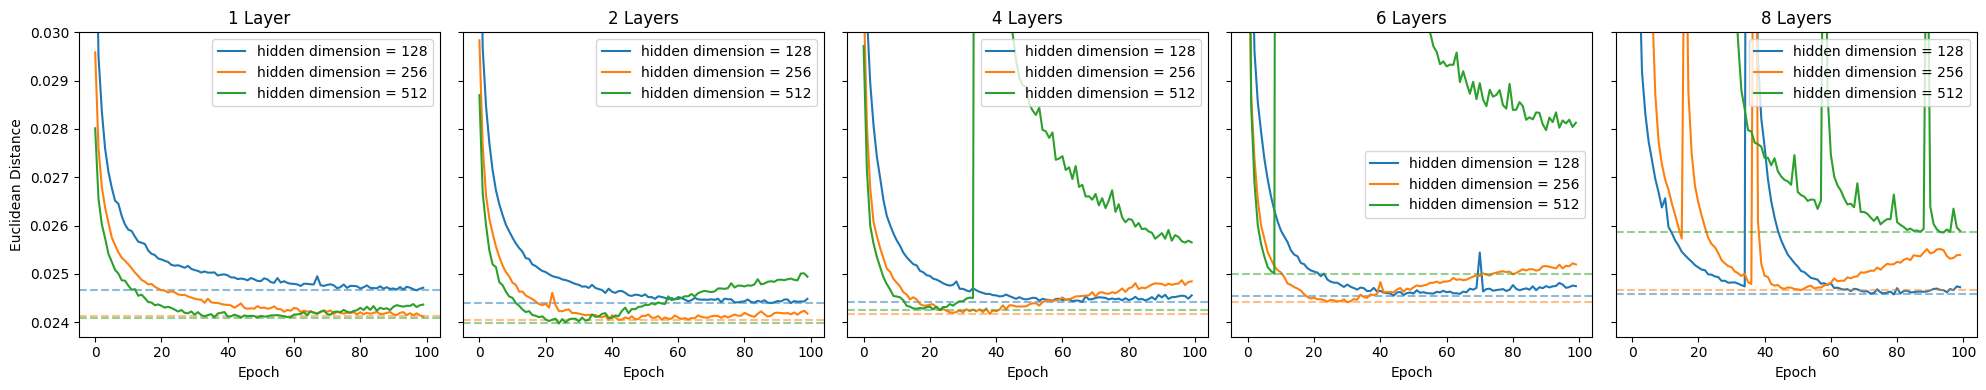

In [ ]:
import matplotlib.pyplot as plt

# サブプロットを作成（1行5列）
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # 横並びに5つのグラフ、縦軸は共有

for j in range(5):
    ax = axes[j]  # 対応するサブプロットの軸を取得

    for index, i in enumerate([j, j+5, j+10]):
        x = experiment_data[i]['metrics_val']['epoch']
        y = experiment_data[i]['metrics_val']['val_loss']
        label = f"hidden dimension = {experiment_data[i]['hidden_dim']}"

        # 横線（最小val_loss）を描画
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][index]
        ax.axhline(y=experiment_data[i]['min_val_loss'], color=color, linestyle='--', alpha=0.5)
        # ax.text(x=index*15, y=experiment_data[i]['min_val_loss'], s=f"{experiment_data[i]['min_val_loss']:.4}", color=color, fontsize=8)
        # グラフの最大を制限
        ax.set_ylim(0.0237, 0.03)
        # 折れ線グラフを描画
        ax.plot(x, y, label=label, color=color)

    # 軸とタイトル
    ax.set_xlabel('Epoch')
    if j == 0:
        ax.set_ylabel('Euclidean Distance')
    ax.set_title(f'{experiment_data[i]["num_layer"]} {"Layers" if experiment_data[i]["num_layer"] > 1 else "Layer"}')
    ax.legend()

# レイアウト調整と表示
plt.tight_layout()
plt.show()


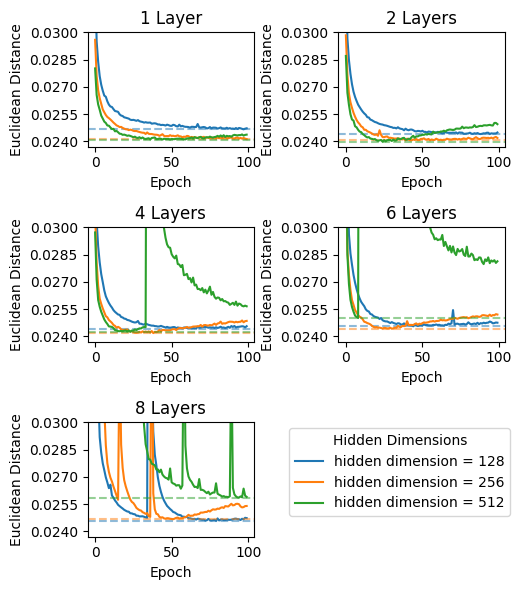

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, axes = plt.subplots(3, 2, figsize=(6, 6), 
                      sharex=False, sharey=False)  # shareyを完全に無効化

# 凡例用のカラーとラベルを管理する辞書
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
hidden_dim_colors = {}
legend_handles = {}
legend_labels = {}

for j in range(5):
    row = j // 2
    col = j % 2
    ax = axes[row, col]

    for i in [j, j+5, j+10]:
        data = experiment_data[i]
        hd = data['hidden_dim']
        
        # 隠れ層次元ごとに一意の色を割り当て
        if hd not in hidden_dim_colors:
            color_idx = len(hidden_dim_colors) % len(color_cycle)
            hidden_dim_colors[hd] = color_cycle[color_idx]
        
        color = hidden_dim_colors[hd]
        label = f"hidden dimension = {hd}"
        
        # 水平線と折れ線をプロット
        ax.axhline(y=data['min_val_loss'], color=color, linestyle='--', alpha=0.5)
        line = ax.plot(data['metrics_val']['epoch'], 
                      data['metrics_val']['val_loss'],
                      color=color)[0]
        
        if hd not in legend_handles:
            legend_handles[hd] = line
            legend_labels[hd] = label
    
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))  # y軸のフォーマットを指定
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Euclidean Distance')  # 全サブプロットにylabelを設定
    ax.set_ylim(0.0237, 0.03)
    ax.set_title(f'{data["num_layer"]} {"Layers" if data["num_layer"] > 1 else "Layer"}')

# 右下のサブプロットを凡例用に設定
ax_legend = axes[2, 1]
ax_legend.axis('off')  # 完全に軸を非表示

# 凡例を右下のサブプロット領域に直接配置
legend = fig.legend(handles=legend_handles.values(),
                  labels=legend_labels.values(),
                  loc='lower right',
                  bbox_to_anchor=(0.87, 0.12),  # 位置を微調整
                  frameon=True,
                  fontsize=10,
                  title='Hidden Dimensions')

# 全サブプロットのy軸を統一（手動でshareyを再現）
y_min, y_max = 0.0237, 0.03
for ax in axes.flatten()[:5]:  # 凡例領域を除く全サブプロット
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # メモリ数を明示的に指定

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 凡例のための余白を確保
plt.show()

In [3]:
experiment_data.sort(key=lambda x: (x['hidden_dim'], x['num_layer']))
for i in range(len(experiment_data)):
    print(f"{i}: Hidden Dim: {experiment_data[i]['hidden_dim']}, Num Layer: {experiment_data[i]['num_layer']}, Min Val Loss: {experiment_data[i]['min_val_loss']}, Min Val Euclidean Distance: {experiment_data[i]['min_val_euclidean_distance']}, Min Train Loss: {experiment_data[i]['min_train_loss']}, Min Train Euclidean Distance: {experiment_data[i]['min_train_euclidean_distance']}")

0: Hidden Dim: 128, Num Layer: 1, Min Val Loss: 0.0246588364243507, Min Val Euclidean Distance: 3.924114227294922, Min Train Loss: 0.0244045257568359, Min Train Euclidean Distance: 3.658980369567871
1: Hidden Dim: 128, Num Layer: 2, Min Val Loss: 0.0243961699306964, Min Val Euclidean Distance: 3.868717193603516, Min Train Loss: 0.0238791238516569, Min Train Euclidean Distance: 3.5624232292175293
2: Hidden Dim: 128, Num Layer: 4, Min Val Loss: 0.0244190618395805, Min Val Euclidean Distance: 3.986879587173462, Min Train Loss: 0.0234887786209583, Min Train Euclidean Distance: 3.5287044048309326
3: Hidden Dim: 128, Num Layer: 6, Min Val Loss: 0.0245503205806016, Min Val Euclidean Distance: 4.119936466217041, Min Train Loss: 0.0231850035488605, Min Train Euclidean Distance: 3.496250867843628
4: Hidden Dim: 128, Num Layer: 8, Min Val Loss: 0.0245761964470148, Min Val Euclidean Distance: 4.263103008270264, Min Train Loss: 0.0234633088111877, Min Train Euclidean Distance: 3.619232892990112
5: 

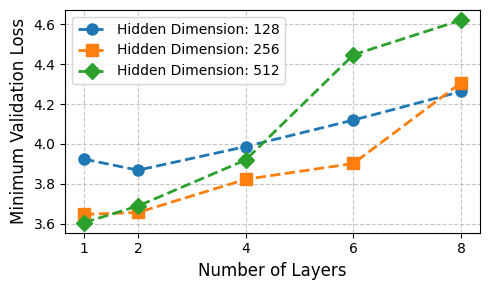

In [100]:
# データをhidden_dimごとにグループ化
hidden_dims = sorted({exp['hidden_dim'] for exp in experiment_data})
num_layers = sorted({exp['num_layer'] for exp in experiment_data})

# プロット設定
plt.figure(figsize=(5, 3))
# colors = ['b', 'g', 'r']
markers = ['o', 's', 'D']

# 各hidden_dimごとにデータをプロット
for idx, h_dim in enumerate([128, 256, 512]):
    # 該当するhidden_dimのデータを抽出し、レイヤー数でソート
    hdim_data = [exp for exp in experiment_data if exp['hidden_dim'] == h_dim]
    hdim_data_sorted = sorted(hdim_data, key=lambda x: x['num_layer'])
    
    # データポイントを抽出
    layers = [exp['num_layer'] for exp in hdim_data_sorted]
    losses = [exp['min_val_euclidean_distance'] for exp in hdim_data_sorted]
    
    # 線とマーカーでプロット
    plt.plot(layers, losses, 
            #  color=colors[idx], 
             marker=markers[idx], 
             linestyle='--',
             linewidth=2,
             markersize=8,
             label=f'Hidden Dimension: {h_dim}')

# グラフの装飾
# plt.title('Minimum Validation Loss vs Number of Layers', fontsize=16)
plt.xlabel('Number of Layers', fontsize=12)
plt.ylabel('Minimum Validation Loss', fontsize=12)
plt.xticks(num_layers)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# パフォーマンス指標を表示
plt.show()

In [99]:
import pandas as pd

# 空のリストでデータを集める
table_data = []

# それぞれの hidden_dim に対して
for index_i, h_dim in enumerate([128, 256, 512]):
    # データを抽出し、レイヤー数でソート
    hdim_data = [exp for exp in experiment_data if exp['hidden_dim'] == h_dim]
    hdim_data_sorted = sorted(hdim_data, key=lambda x: x['num_layer'])
# f"{experiment_data[i]['min_val_loss']:.4}"
    # 各実験からテーブル用の情報を取り出す
    for index_j, exp in enumerate(hdim_data_sorted):
        table_data.append({
            'Model': f"Model {(index_i)* 5 +  (index_j+1)}",
            'Hidden Dimension': h_dim,
            'Number of Layers': exp['num_layer'],
            # 'MSE': exp['min_val_loss'],
            'MSE': f"{exp['min_val_loss']:.4}",
            # 'Endpoint Error': exp['min_val_euclidean_distance'],
            'Endpoint Error': f"{exp['min_val_euclidean_distance']:.5}",
        })

# pandasのDataFrameとして表示
df = pd.DataFrame(table_data)
df = df.sort_values(by=['Hidden Dimension', 'Number of Layers']).reset_index(drop=True)
print(df)


       Model  Hidden Dimension  Number of Layers      MSE Endpoint Error
0    Model 1               128                 1  0.02466         3.9241
1    Model 2               128                 2   0.0244         3.8687
2    Model 3               128                 4  0.02442         3.9869
3    Model 4               128                 6  0.02455         4.1199
4    Model 5               128                 8  0.02458         4.2631
5    Model 6               256                 1  0.02412          3.647
6    Model 7               256                 2  0.02405         3.6569
7    Model 8               256                 4  0.02417         3.8229
8    Model 9               256                 6  0.02441         3.9026
9   Model 10               256                 8  0.02467         4.3074
10  Model 11               512                 1  0.02409          3.606
11  Model 12               512                 2  0.02398         3.6891
12  Model 13               512                 4  0

In [ ]:
# Model  1 & 128 & 1 & 0.02466 & 3.9241 \\
# Model  2 & 128 & 2 & 0.02440 & 3.8687 \\
# Model  3 & 128 & 4 & 0.02442 & 3.9869 \\
# Model  4 & 128 & 6 & 0.02455 & 4.1199 \\
# Model  5 & 128 & 8 & 0.02458 & 4.2631 \\
# Model  6 & 256 & 1 & 0.02412 & 3.6470 \\
# Model  7 & 256 & 2 & 0.02405 & 3.6569 \\
# Model  8 & 256 & 4 & 0.02417 & 3.8229 \\
# Model  9 & 256 & 6 & 0.02441 & 3.9026 \\
# Model 10 & 256 & 8 & 0.02467 & 4.3074 \\
# Model 11 & 512 & 1 & 0.02409 & 3.6060 \\
# Model 12 & 512 & 2 & 0.02398 & 3.6891 \\
# Model 13 & 512 & 4 & 0.02425 & 3.9202 \\
# Model 14 & 512 & 6 & 0.02500 & 4.4472 \\
# Model 15 & 512 & 8 & 0.02586 & 4.6209 \\